# Deep Learning &mdash; Assignment 7

Seventh assignment for the 2023 Deep Learning course (NWI-IMC070) of the Radboud University.

-----

**Names: Luka Mucko, Luca Poli**

**Group: 46**

-----

## Introduction

For this assignment we are doing things a bit different.
* Your task is to reproduce the paper [The Lottery Ticket Hypothesis: Finding Sparse, Trainable Neural Networks;      Jonathan Frankle, Michael Carbin](https://arxiv.org/pdf/1803.03635.pdf).
* Try to follow the experimental settings in that paper, unless there is a reason to deviate.
* If the paper is not clear on some details, make a reasonable choice yourself, and motivate that choice.
* You will have 3 weeks to work on this assignment.
* Be aware that this assignment will take more time than previous ones. It is ok if you do not completely finish it.
* We will *not* be providing you with much code. You will have to implement many things yourself.
* You may freely use code from earlier weeks, and from the d2l books. Please add a comment to reference the original source.
* You may *not* use implementations of the paper you find online.

**Tips and hints**
* It is allowed and recommended to use more than just this notebook. Make separate python files for a library of functions, and for training and analyses.
* If you like working with jupyter notebooks: make a separate notebook for trying things out, and keep this one clean.
* Use checkpoint files before and during training.
* In the notebook only display and discuss these results.
* You may add new cells to this notebook as needed.
* While the task is to reproduce parts of a paper, the big picture is more important than the exact details.
* It is allowed to discuss the assignment with other groups, but try not to spoil too much.
* If you get stuck, contact the teachers via discord.

## Required software

If you need to import any additional libraries, add them below.

In [23]:
import pandas as pd
%config InlineBackend.figure_formats = ['png']
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import torch
import torch.nn
import torch.nn.utils.prune as prune
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from d2l import torch as d2l
from dl_assignment_7_common import *  # Your functions should go here if you want to use them from scripts

device = d2l.try_gpu()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 7.1 The paper (2 points)

**(a) Read sections 1, 2, and 5 of the paper [The Lottery Ticket Hypothesis: Finding Sparse, Trainable Neural Networks; by Jonathan Frankle, Michael Carbin](https://arxiv.org/pdf/1803.03635.pdf)**

We will refer to this as the "LTH paper" from now on, or just "the paper".
To answer some later questions you will also need to look at other sections, and search through the appendices.

**(b) In your own words, briefly explain the key message of the paper.<span style="float:right"> (2 points)</span>**

Note: "briefly" means: a few sentences at most.

The key message of the paper, is that in large neural network there exist smaller subnetwork (called winning tickets) that can be trained in isolation to achieve comparable performance to the original network (or even better) in less epochs. The winning tickets are found with an iterative process of pruning and retraining.

## 7.2 Models and datasets (9 points)

**(a) What neural network architectures are used in the paper?<span style="float:right"> (1 point)</span>**

In the paper the network architectures used are: Lenet, Conv-2, Conv-4, Conv-6, Resnet-18 and VGG-19.

To keep things simple, we will start with a simple architecture, corresponding to what the paper calls `Lenet`.

**(b) Define a function that constructs a `Lenet` network using PyTorch.<span style="float:right"> (2 points)</span>**

Copy these definitions to `dl_assignment_7_common.py`.

Hint: see Figure 2.

Note: the LTH paper is not entirely clear about this, but the convolution layers use `padding='same'`.

In [25]:
for net_type in ["lenet", "resnet18", "vgg19"]:
    print(f"{net_type}: {sum(p.numel() for p in create_network(net_type).parameters())} parameters")

lenet: 266610 parameters
resnet18: 11181642 parameters
vgg19: 139611210 parameters


**(c) Define a function that can construct a network given the architecture name.**

To keep the code as generic as possible, we can make function

Move the function below to `dl_assignment_7_common.py`, and don't forget to remove it here.

We will do all our experiments with two datasets: MNIST and FashionMNIST

**(d) Are these datasets also used in the papers?<span style="float:right"> (1 point)</span>**

In the paper they use MNIST and CIFAR10, so the dataset FashionMNIST is not used the paper.

**(e) Define a function that loads a dataset given the dataset name.<span style="float:right"> (3 points)</span>**

Hint: Standard datasets such as MNIST and CIFAR10 are available in the [torchvision](https://pytorch.org/vision/stable/datasets.html#image-classification) library.

TODO: Function implemented as: `TODO` in `dl_assignment_7_common.py`

**(f) Most of these datasets come with a predefined train/test split. Is this used in the LTH paper? If so, update the dataset loader to return a pair `(trainset, testset)`.<span style="float:right"> (1 point)</span>**

In the paper they use the predefined train/test split, which is 60000 training images and 10000 test images for MNIST and 50000 training images and 10000 test images for CIFAR10.

**(g) Does the LTH paper use a validation set? If so, update the dataset loader to return `(train_dataset, validation_dataset, test_dataset)`.<span style="float:right"> (1 point)</span>**

Hint: [`random_split`](https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split), and/or see assignment 2.

In the paper they have sampled a validation set of 5000 images from the training set.

In [26]:
for dataset in ["MNIST", "CIFAR10" ,"FashionMNIST"]:
    train_data, validation_data, test_data = get_dataloaders(dataset)
    print(f"{dataset}: {len(train_data.dataset)} training images, {len(validation_data.dataset)} validation images, {len(test_data.dataset)} test images")

MNIST: 55000 training images, 5000 validation images, 10000 test images
Files already downloaded and verified
Files already downloaded and verified
CIFAR10: 45000 training images, 5000 validation images, 10000 test images
FashionMNIST: 55000 training images, 5000 validation images, 10000 test images


## 7.3 Training (12 points)

**(a) What optimization algorithm is used in the paper? What values are used for the hyperparameters?<span style="float:right"> (1.5 points)</span>**

If you are unable to find the values used for some of the hyperparameters, use reasonable default values.

ADAM was used as the optimizer for Lenet and Conv networks, for resnet and VGG SGD with momentum was used. <br/>
By default the use learning rate of $1.2\cdot 10^{-3}$ for Lenet and Conv networks and experiment with other learning rates: $3\cdot 10^{-4}$ and $2\cdot 10^{-4}$ <br/>
For sgd with momentum they used learning rates 0.1-0.01-0.001 and momentum 0.9

**(b) Implement an evaluation function, that evaluates a model on a validation or test set (passed as an argument).<span style="float:right"> (2 points)</span>**

The function should return loss and accuracy.

Hints: the book defines a function for this that you may use (see assignment 3).

**(c) Implement a training loop.<span style="float:right"> (4 points)</span>**

Make sure that the network parameters are saved to a file before and during training.

Because you will be doing many experiments, it would be a shame to have to re-run them when you reload the notebook. A better solution is to save model checkpoints.
See [the tutorial on saving and loading model parameters](https://pytorch.org/tutorials/beginner/basics/saveloadrun_tutorial.html) for how to implement this in PyTorch.

**(d) Change the training function so that it saves the model at the start and at the end of training.<span style="float:right"> (1 point)</span>**

Hint: Saving a model requires a filename. Because you will be running many experiments, come up with a descriptive naming convention and/or directory structure. Example: `path = f"checkpoints/model-{arch}-{dataset}-{run}-{phase_of_the_moon}-{iteration}.pth"`.

Hint 2: it is easier to save the whole model, see the bottom of the tutorial.

**(e) Train a simple network on a simple dataset.<span style="float:right"> (1 point)</span>**

You may want to create a new python script (`simple_training.py`), and just load the trained network here instead.

simple training #1 : train loss 0.011, train acc 0.997, valid loss 0.168, valid acc 0.976, test loss 0.142, test acc 0.979


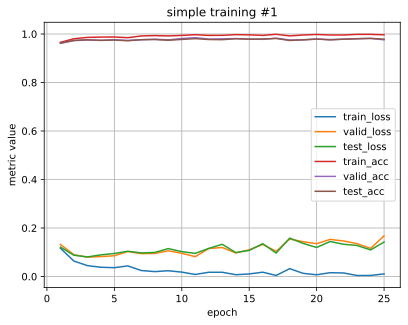

In [21]:
simple_train1, history1 = load_network("simple_train1", lr=lr, optimizer="adam")
print_plot_results_model(history1, "simple training #1")

**(f) Does the training converge? How well does your network perform?<span style="float:right"> (1 point)</span>**

The training converges really quickly to high test accuracy, after that the network overfits which is visible by the increase of validation loss. <br/>
The network performs extremely well with 98% test accuracy.

**(g) Re-train the same network, with the *same* initial weights. Are the results *exactly* the same?<span style="float:right"> (2 points)</span>**

simple training #2 : train loss 0.010, train acc 0.997, valid loss 0.142, valid acc 0.978, test loss 0.150, test acc 0.979


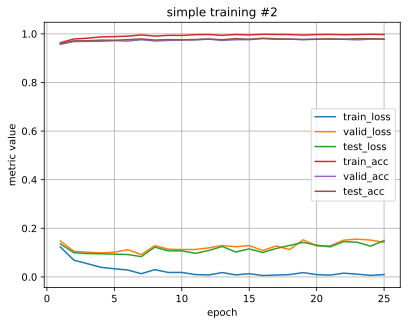

In [22]:
simple_train2, history2 = load_network("simple_train2", lr=lr, optimizer="adam")
print_plot_results_model(history2, "simple training #2")

The results are almost exactly the same, differences are negligible.

**(h) The LTH paper uses a variant of 'early-stopping'. How is this done? Implement it in your training loop.<span style="float:right"> (1 point)</span>**

Hint: A simple way to keep track of the best model is to create a model checkpoint in a file `"checkpoints/model-...-best.pth"`.

Hint 2: It is okay to compute the validation scores less often, this can speed up training.

In the paper they use a retroactive variant of early stopping. They train a network for a fixed number of iterations, and then, with the validations performance they select the moment with the best network.

## 7.4 Pruning (13 points)

Next up, you should implement pruning. Starting with the one-shot pruning method.

Hint: 
Pruning is implemented already in PyTorch, in the module [torch.utils.prune](https://pytorch.org/docs/stable/nn.html#module-torch.nn.utils).
The pruning method used in the LTH paper corresponds is called [l1_unstructured](https://pytorch.org/docs/stable/generated/torch.nn.utils.prune.l1_unstructured.html) in PyTorch.

**(a) The PyTorch pruning function accepts an amount to prune. Is that the amount of weights to set to 0 or the amount to keep nonzero? Is the paper using the same?<span style="float:right"> (1 point)</span>**

The amount in the pytorch pruning function is the amount to set to 0. In the paper they indicate whit p% the amount to prune (like in pytorch) but the result are expressed with Pm which is the percentage of weights remaining.

**(b) Should all parameters be pruned or only weights? Is the pruning rate the same for all types of layers?<span style="float:right"> (1 point)</span>**

Pruning biases can lead to difficulties in training the network effectively, so we should only prune weights (like in the paper). The pruning rate change for different types of layers (for fully connected and convolutional layers), but it does not depend on the layer position (except for the connections to the last layer).

**(c) Define a function to prune a network as used in the LTH paper. It should take an amount to prune as an argument.<span style="float:right"> (3 points)</span>**

Hint: for a `Sequential` layer, you can access the layers as `net.children()`. For a layer, you can use `isinstance(layer, torch.nn.Linear)` to check if it is a linear layer.

TODO: Function implemented as: `TODO` in `dl_assignment_7_common.py`.

**(d) Check your pruning function on a very simple neural network. Print the layer weights before and after pruning to make sure you understand what is going on.<span style="float:right"> (1 point)</span>**

Hint: the PyTorch pruning functions do not change the trainable parameters, rather they set `module.weight` to `weight_orig * weight_mask`.

In [16]:
for net_type in ["lenet", "resnet18", "vgg19"]:
    net = create_network(net_type)
    params_before = sum(p.numel() for p in net.parameters())
    prune_network(net, net_type, 0.5)
    params_after = params_before - sum(torch.sum(b == 0) for b in net.buffers()).item()
    print("Net: " + net_type + " Before pruning: " + str(params_before) + " After pruning: " + str(params_after) +
          " Pruned: " + str(round(abs(1-(params_after / params_before))*100, 2)))

Net: lenet Before pruning: 266610 After pruning: 133760 Pruned: 49.83
Net: conv2 Before pruning: 4301642 After pruning: 2151786 Pruned: 49.98
Net: conv4 Before pruning: 2425930 After pruning: 1214058 Pruned: 49.95
Net: resnet18 Before pruning: 282938 After pruning: 142306 Pruned: 49.7
Net: vgg19 Before pruning: 20029514 After pruning: 10020074 Pruned: 49.97


In [17]:
net_type = "lenet"
net = create_network(net_type)
print("Before: " + str(list(net.children())[0].weight))
prune_network(net, net_type, 0.2)
print("After: " + str(list(net.children())[0].weight))

Before: Parameter containing:
tensor([[ 0.0145, -0.0049,  0.0242,  ..., -0.0266, -0.0234,  0.0284],
        [-0.0113,  0.0273,  0.0011,  ...,  0.0241, -0.0180, -0.0321],
        [ 0.0286,  0.0233,  0.0346,  ...,  0.0018, -0.0036, -0.0119],
        ...,
        [-0.0067,  0.0227,  0.0083,  ..., -0.0289,  0.0171,  0.0136],
        [-0.0031,  0.0099, -0.0295,  ..., -0.0125, -0.0154, -0.0251],
        [-0.0161, -0.0237,  0.0043,  ..., -0.0099,  0.0129, -0.0314]],
       requires_grad=True)
After: tensor([[ 0.0145, -0.0000,  0.0242,  ..., -0.0266, -0.0234,  0.0284],
        [-0.0113,  0.0273,  0.0000,  ...,  0.0241, -0.0180, -0.0321],
        [ 0.0286,  0.0233,  0.0346,  ...,  0.0000, -0.0000, -0.0119],
        ...,
        [-0.0000,  0.0227,  0.0083,  ..., -0.0289,  0.0171,  0.0136],
        [-0.0000,  0.0099, -0.0295,  ..., -0.0125, -0.0154, -0.0251],
        [-0.0161, -0.0237,  0.0000,  ..., -0.0099,  0.0129, -0.0314]],
       grad_fn=<MulBackward0>)


**(e) Define a function that applies the pruning mask from a pruned network to another network of the same architecture.<span style="float:right"> (2 points)</span>**

This function should only do pruning (so some weights become 0), other weights should remain the same.

Hint: the pruning functions already generate and store pruning masks. You should be able to extract these from a pruned network.

Hint 2: `custom_from_mask`

TODO: Function implemented as: `TODO` in `dl_assignment_7_common.py`

**(f) Check your mask copy function on a very simple neural network. Check that only the pruning mask is copied.<span style="float:right"> (1 point)</span>**

In [19]:
net_type = "lenet"
net_in = create_network(net_type)
prune_network(net_in, net_type, 0.3)

net_out = create_network(net_type)
print("Before: " + str(list(net_out.children())[0].weight))
params_before = sum(p.numel() for p in net.parameters())

prune_network_from_mask(net_in, net_out)
params_after = params_before - sum(torch.sum(b == 0) for b in net_out.buffers()).item()
print("After: " + str(list(net_out.children())[0].weight))

print("Before pruning: " + str(params_before) + " After pruning: " + str(params_after) +
      " Pruned: " + str(round(abs(1-(params_after / params_before))*100, 2)))

Before: Parameter containing:
tensor([[-0.0075, -0.0188,  0.0311,  ..., -0.0330, -0.0178,  0.0280],
        [ 0.0076,  0.0107,  0.0211,  ...,  0.0009, -0.0283,  0.0081],
        [-0.0292, -0.0038,  0.0200,  ..., -0.0116, -0.0153,  0.0259],
        ...,
        [ 0.0324,  0.0086,  0.0115,  ...,  0.0066,  0.0319, -0.0295],
        [-0.0009,  0.0058,  0.0264,  ..., -0.0131, -0.0017, -0.0036],
        [ 0.0344,  0.0166, -0.0171,  ..., -0.0148, -0.0139, -0.0031]],
       requires_grad=True)
After: tensor([[-0.0075, -0.0188,  0.0311,  ..., -0.0000, -0.0000,  0.0280],
        [ 0.0076,  0.0107,  0.0000,  ...,  0.0009, -0.0283,  0.0081],
        [-0.0000, -0.0000,  0.0200,  ..., -0.0000, -0.0153,  0.0259],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0066,  0.0319, -0.0295],
        [-0.0009,  0.0000,  0.0264,  ..., -0.0000, -0.0017, -0.0036],
        [ 0.0344,  0.0166, -0.0171,  ..., -0.0148, -0.0139, -0.0031]],
       grad_fn=<MulBackward0>)
Before pruning: 266610 After pruning:

**(g) Define a function that randomly prunes a network.<span style="float:right"> (1 point)</span>**

TODO: Function implemented as: `TODO` in `dl_assignment_7_common.py`

**(h) Check the above function.<span style="float:right"> (1 point)</span>**

In [18]:
for net_type in ["lenet", "resnet18", "vgg19"]:
    net = create_network(net_type)
    params_before = sum(p.numel() for p in net.parameters())
    prune_network(net, net_type, 0.2, prune_type=prune.RandomUnstructured)
    params_after = params_before - sum(torch.sum(b == 0) for b in net.buffers()).item()
    print("Net: " + net_type + " Before pruning: " + str(params_before) + " After pruning: " + str(params_after) +
          " Pruned: " + str(round(abs(1-(params_after / params_before))*100, 2)))

Net: lenet Before pruning: 266610 After pruning: 213470 Pruned: 19.93
Net: resnet18 Before pruning: 282308 After pruning: 226055 Pruned: 19.93
Net: vgg19 Before pruning: 20024404 After pruning: 16020628 Pruned: 19.99


**(i) Define a function that performs the experiment described in Section 1 of the LTH paper on a given dataset and with a given architecture.<span style="float:right"> (2 points)</span>**

Save all needed results to a file, such as test loss and accuracy. This will make your job easier later on.

TODO: Function implemented as: `TODO` in `dl_assignment_7_common.py`

## 7.5 Confirming the Lottery Ticket Hypothesis (10 points)

**(a) Perform the experiments needed to reproduce the red lines in Figure 1 from the LTH paper.<span style="float:right"> (6 points)</span>**

* It is ok to ignore the error bars for now, and focus on doing one series of experiments.
* You may also reduce the number of points in the plot to keep the computation time managable.
* You do not have to match the visual style of the figure.

Hint: create a python script (`experiment1-{dataset}-{method}.py`) that does all the training as needed.
Then load the checkpoint files and do your analysis here.
You may also want to define more helper functions.

Hint 2: look at previous assignments for how to plot. If you do want to include error bars, see also [documentation for `plt.errorbar`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.errorbar.html).

TODO: Training implemented in `TODO.py`

In [29]:
# TODO: your code here
folder = os.path.join("checkpoints")
pretrained = {"best_epoch": [], "test_acc": []}
untrained = {"best_epoch": [], "test_acc": []}
prune_percentages = np.array([99.5, 99, 95, 90, 75, 50, 10, 0]) / 100
for p in prune_percentages:
    for state in ["pretrained","untrained"]:
        if p==0. and state=="untrained":
            continue
        net, history = load_network(experiment_name = f"{p}_{state}_lenet", lr = 1.2e-3, optimizer="adam", save_path=folder)
        best_epoch = history["early_stop_epoch"][-1]
        if state=="pretrained":
            pretrained["best_epoch"].append(best_epoch)
            pretrained["test_acc"].append(history["test_acc"][best_epoch-1])
            if p==0.:
                untrained["best_epoch"].append(best_epoch)
                untrained["test_acc"].append(history["test_acc"][best_epoch-1])
        elif state=="untrained":
            untrained["best_epoch"].append(best_epoch)
            untrained["test_acc"].append(history["test_acc"][best_epoch-1])

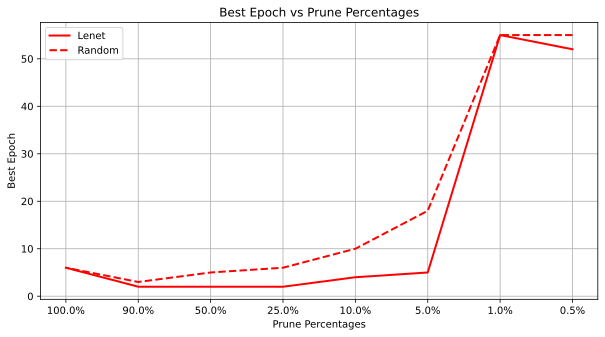

In [30]:
plt.figure(figsize=(10,5))
x=[8,7,6,5,4,3,2,1]
plt.plot(x, pretrained['best_epoch'], 'r-', label='Lenet', linewidth=2)
plt.plot(x, untrained['best_epoch'], 'r--', label='Random', linewidth=2)
plt.xlabel('Prune Percentages')
plt.ylabel('Best Epoch')
plt.title('Best Epoch vs Prune Percentages')
plt.xticks(x, [str(round(((1-p)*100),2))+"%" for p in prune_percentages])
plt.legend()
plt.grid(True)

plt.show()

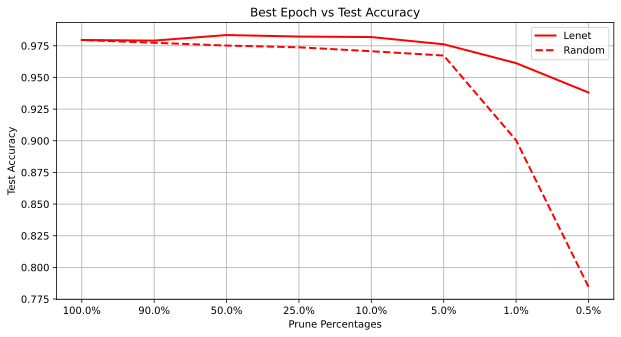

In [31]:
plt.figure(figsize=(10, 5))
x=[8,7,6,5,4,3,2,1]
plt.plot(x, pretrained['test_acc'], 'r-', label='Lenet', linewidth=2)
plt.plot(x, untrained['test_acc'], 'r--', label='Random', linewidth=2)
plt.xlabel('Prune Percentages')
plt.ylabel('Test Accuracy')
plt.title('Best Epoch vs Test Accuracy')
plt.xticks(x, [str(round(((1-p)*100),2))+"%" for p in prune_percentages])
plt.legend()
plt.grid(True)

plt.show()


**(b) Do your results match the paper? Discuss similarities and differences.<span style="float:right"> (2 points)</span>**

Yes! The graphs are equivalent to those in the paper. 

Test accuracy for pruned untrained networks is lower than that of pretrained pruned networks for all amounts of prune percentages we used. <br/>
The best epoch with respect to lowest validation loss is higher for untrained pruned networks than pretrained pruned networks. We can also observe the unusual decrease in the value of best epoch at the 99%+ pruning rate (1%< remaining parameters), same can be observed in figure 1 of the paper.

**(c) What can you conclude from this experiment?<span style="float:right"> (2 points)</span>**

Our conclusion from both graphs is the same as in footnote 1: <br/>
"Training a pruned model from scratch performs worse than retraining a pruned model....” (Li et al., 2016)

"During retraining, it is better to retain the weights from the initial training phase for the connections that survived pruning than it is to re-initialize the pruned layers..."(Han et al., 2015)

## 7.6 Experiments from Section 2 (12 points)

**(a) What is the difference between the experiment in Figure 1 and Figure 3 of the paper.<span style="float:right"> (1 point)</span>**

Hint: are there differences in the method, the architecture, or the dataset?

The only difference is in the pruning methodology. Figure 3 uses iterative pruning where after training for j iterations we prune and continue training for j iterations then repeating our pruning and training until we reach minimum percentage of remaining weights. Where in Figure 1 only one network is trained then it is pruned for several percentages, all those new network (pretrained and reinitialized) are then retrained.

**(b) Implement the iterative pruning method from the paper.<span style="float:right"> (3 points)</span>**

TODO: Function implemented as: `TODO` in `dl_assignment_7_common.py`

**(c) Perform the experiments needed to reproduce Figure 4a from the paper.<span style="float:right"> (4 points)</span>**

Hint: see previous section

TODO: Training implemented in `TODO.py`

In [45]:
def load_epoch_stats(path):
    return pd.read_csv(os.path.join(path, "epoch_stats.csv"), index_col="epoch").to_dict(orient="list")

trained_base_dir = "iterative/iterative_reinit/trained_{percentage}_0.0012_adam_0"
untrained_base_dir = "iterative/iterative_reinit/untrained_reinit/reinit_{percentage}_0.0012_adam_0"

trained_results = {}
untrained_results = {}

percentages = [p.split("_")[1] for p in os.listdir("iterative/iterative_reinit/") if p.startswith("trained")]
percentages.sort()
trained_results = {float(p): {"best_epoch": [], "test_acc": [], "train_acc": []} for p in percentages}
untrained_results = {float(p): {"best_epoch": [], "test_acc": [], "train_acc": []} for p in percentages}

for percentage in percentages:
    p=float(percentage)
    trained_path = os.path.join(trained_base_dir.format(percentage=percentage))
    trained_stats=load_epoch_stats(trained_path)
    best_epoch = trained_stats["early_stop_epoch"][-1]
    trained_results[p]["best_epoch"] = trained_stats["early_stop_epoch"][-1]
    trained_results[p]["test_acc"] = trained_stats["test_acc"][best_epoch-1]
    trained_results[p]["train_acc"] = trained_stats["train_acc"][best_epoch-1]

    if p==100.0:
        untrained_path=os.path.join(trained_base_dir.format(percentage=percentage))
    else:
        untrained_path = os.path.join(untrained_base_dir.format(percentage=percentage))
    untrained_stats = load_epoch_stats(untrained_path)
    best_epoch = untrained_stats["early_stop_epoch"][-1]
    untrained_results[p]["best_epoch"] = best_epoch
    untrained_results[p]["test_acc"] = untrained_stats["test_acc"][best_epoch-1]
    untrained_results[p]["train_acc"] = untrained_stats["train_acc"][best_epoch-1]

percentages = [float(p) for p in percentages]
percentages.sort()

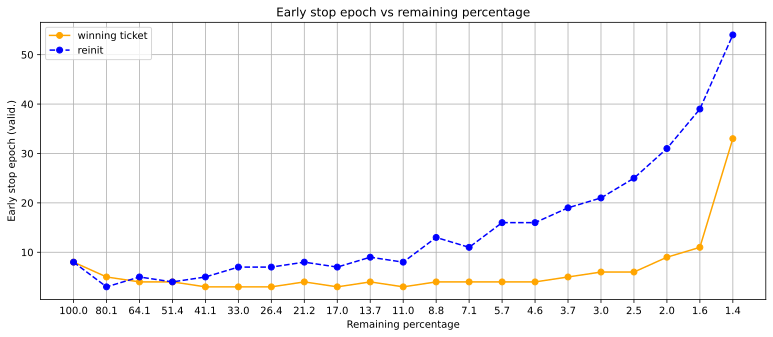

In [46]:
x_values = list(range(1,22))

# Plotting
plt.figure(figsize=(13, 5))

y_values = [trained_results[p]['best_epoch'] for p in sorted(trained_results.keys(), reverse=True)]
plt.plot(x_values, y_values, color='orange', linestyle='solid', marker='o', label="winning ticket")

y_values = [untrained_results[p]['best_epoch'] for p in sorted(untrained_results.keys(), reverse=True)]
plt.plot(x_values, y_values, color="blue", linestyle="dashed", marker="o", label="reinit")

plt.xlabel('Remaining percentage')
plt.ylabel('Early stop epoch (valid.)')
plt.title('Early stop epoch vs remaining percentage')
plt.grid(True)
plt.xticks(x_values, [f'{p:.1f}' for p in sorted(trained_results.keys(), reverse=True)])
plt.legend()
plt.show()

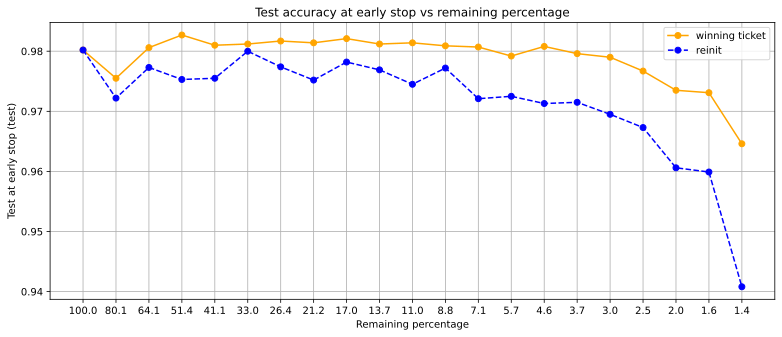

In [47]:
plt.figure(figsize=(13, 5))

y_values = [trained_results[p]['test_acc'] for p in sorted(trained_results.keys(), reverse=True)]
plt.plot(x_values, y_values, color='orange', linestyle='solid', marker='o', label="winning ticket")

y_values = [untrained_results[p]['test_acc'] for p in sorted(untrained_results.keys(), reverse=True)]
plt.plot(x_values, y_values, color="blue", linestyle="dashed", marker="o", label="reinit")

plt.xlabel('Remaining percentage')
plt.ylabel('Test at early stop (test)')
plt.title('Test accuracy at early stop vs remaining percentage')
plt.grid(True)
plt.xticks(x_values, [f'{p:.1f}' for p in sorted(trained_results.keys(), reverse=True)])
plt.legend()
plt.show()

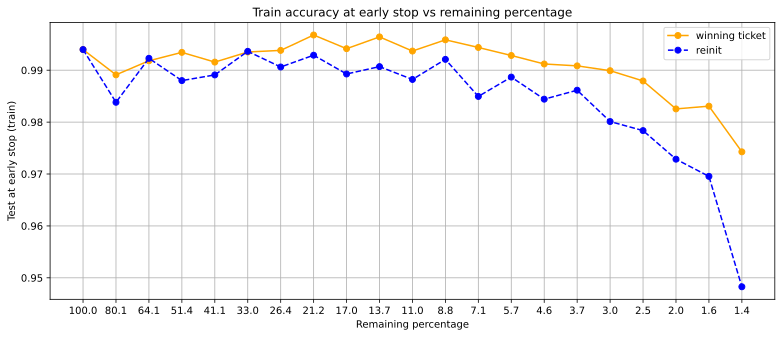

In [48]:
plt.figure(figsize=(13, 5))

y_values = [trained_results[p]['train_acc'] for p in sorted(trained_results.keys(), reverse=True)]
plt.plot(x_values, y_values, color='orange', linestyle='solid', marker='o', label="winning ticket")

y_values = [untrained_results[p]['train_acc'] for p in sorted(untrained_results.keys(), reverse=True)]
plt.plot(x_values, y_values, color="blue", linestyle="dashed", marker="o", label="reinit")

plt.xlabel('Remaining percentage')
plt.ylabel('Test at early stop (train)')
plt.title('Train accuracy at early stop vs remaining percentage')
plt.grid(True)
plt.xticks(x_values, [f'{p:.1f}' for p in sorted(trained_results.keys(), reverse=True)])
plt.legend()
plt.show()

**(d) Do your results match the paper? Discuss similarities and differences.<span style="float:right"> (2 points)</span>**

The results are equivalent to those in the paper with minor differences (we did not include the oneshot plot from 7.5). <br/>
Early stop epoch increases with the amount of weights pruned. <br/>
Test accuracy in our testing is stagnant for p>=3% while it increases in the paper, it then falls off around 3% same as in the paper. <br/>
Train accuracy increases with percent of weights removed until around 3%  where it starts falling off as in the paper. <br/>

**(e) What can you conclude from this experiment?<span style="float:right"> (2 points)</span>**

We can come up with the same conclusion as in the paper: <br/>
"Winning tickets learn faster as they are pruned, they learn progressively slower when randomly reinitialized" <br/> 
"The reinitialized networks learn increasingly slower than the original network and lost test accuracy after little pruning" <br/>

## 7.7 Experiments from Section 4 (7 points)

Section 3 and 4 deal with convolutional neural networks. We are going to skip the networks in section 3, and move on to Figure 8.

**(a) Section 4 of the paper describes a slightly different pruning method. Implement that method.<span style="float:right"> (2 points)</span>**

Hint: look at [`torch.nn.utils.prune.global_unstructured`](https://pytorch.org/docs/stable/generated/torch.nn.utils.prune.global_unstructured.html) and at the examples on that page.

If you get stuck on this step, you can continue with the same pruning methods as before.

TODO: Function implemented as: `TODO` in `dl_assignment_7_common.py`

**(b) Implement a function that constructs the network architecture used in Figure 8.<span style="float:right"> (1 point)</span>**

Extend the `create_network` function defined earlier.

Hint: VGG16 and Resnet18 are [predefined in torchvision](https://pytorch.org/vision/0.12/models.html).

**(c) Perform the experiments needed to reproduce Figure 8 from the LTH paper.<span style="float:right"> (2 points)</span>**

* Again: you do not need to include error bars.
* You may limit yourself to one of the figures.

TODO: Training implemented in `TODO.py`

In [13]:
trained_base_dir = "iterative/iterative_resnet/trained_{percentage}_0.001_sgd_0.9"
untrained_base_dir = "iterative/iterative_resnet/reinit_{percentage}_0.001_sgd_0.9"

trained_results = {}
untrained_results = {}

percentages = [p.split("_")[1] for p in os.listdir("iterative/iterative_resnet/") if p.startswith("trained")]
percentages.sort()
trained_results = {float(p): {"test_acc": [], "train_acc": []} for p in percentages}
untrained_results = {float(p): {"test_acc": [], "train_acc": []} for p in percentages}

for percentage in percentages:
    p=float(percentage)
    trained_path = os.path.join(trained_base_dir.format(percentage=percentage))
    trained_stats=load_epoch_stats(trained_path)
    trained_results[p]["test_acc"] = trained_stats["test_acc"][-1]
    trained_results[p]["train_acc"] = trained_stats["train_acc"][-1]

    if p==100.0:
        untrained_path=os.path.join(trained_base_dir.format(percentage=percentage))
    else:
        untrained_path = os.path.join(untrained_base_dir.format(percentage=percentage))
        
    untrained_stats = load_epoch_stats(untrained_path)
    untrained_results[p]["test_acc"] = untrained_stats["test_acc"][-1]
    untrained_results[p]["train_acc"] = untrained_stats["train_acc"][-1]

percentages = [float(p) for p in percentages]
percentages.sort()

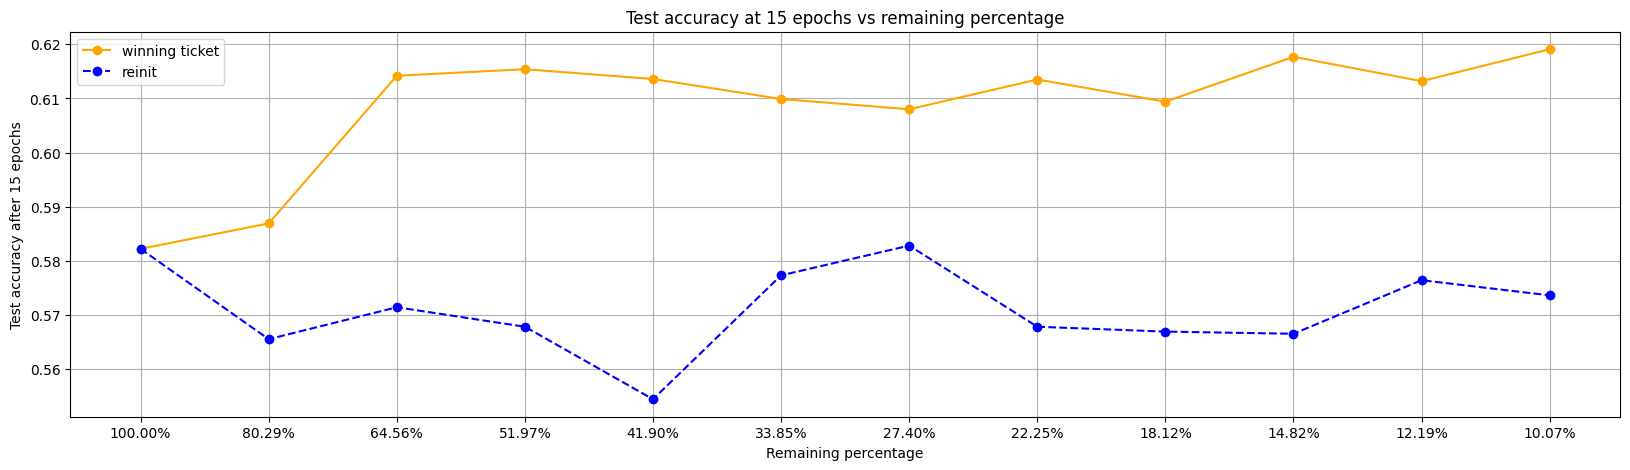

In [14]:
plt.figure(figsize=(20, 5))
x_values = list(range(1, len(percentages)+1))
y_values = [trained_results[p]['test_acc'] for p in sorted(trained_results.keys(), reverse=True)]
plt.plot(x_values, y_values, color='orange', linestyle='solid', marker='o', label="winning ticket")

y_values = [untrained_results[p]['test_acc'] for p in sorted(untrained_results.keys(), reverse=True)]
plt.plot(x_values, y_values, color="blue", linestyle="dashed", marker="o", label="reinit")

plt.xlabel('Remaining percentage')
plt.ylabel('Test accuracy after 15 epochs')
plt.title('Test accuracy at 15 epochs vs remaining percentage')
plt.grid(True)
plt.xticks(x_values, [f'{p:.2f}%' for p in sorted(trained_results.keys(), reverse=True)])
plt.legend()
plt.show()

**(d) Do your results match the paper? Discuss similarities and differences.<span style="float:right"> (2 points)</span>**

The result are similar to those in the paper, we can observe a similar trend to the papers graph, regarding the test accuracy of winning ticket vs random reinitialization. Indeed, we can observe that the test accuracy of the winning ticket is higher than the random reinitialization for all prune percentages.
We have also found, during the experiments, that is easier to find winning ticket with lower learning rate.

## The end

Well done! Please double check the instructions at the top before you submit your results.

*This assignment has 65 points.*
<span style="float:right;color:#aaa;font-size:10px;"> Version 97b3d19 / 2023-10-19</span>